In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from models.blindconvolution import BiConvolution

from utils.sr_utils import *

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark =False
#dtype = torch.cuda.FloatTensor
dtype = torch.FloatTensor


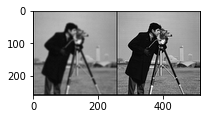

(1, 9, 9)

In [2]:
# Starts here
path_LR_image = 'data/sr/Cameraman256_gauss.png'
path_HR_image = 'data/sr/Cameraman256.png'
kernel_path ='data/sr/kernel_gauss.png'
img_k_pil, img_k_np = get_image(kernel_path, -1)
img_lr_pil, img_lr_np = get_image(path_LR_image, -1)
img_hr_pil, img_hr_np = get_image(path_HR_image, -1)
plot_image_grid([img_lr_np,img_hr_np])
img_k_np.shape

In [3]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='udf'
kernel_path ='data/sr/kernel_gauss.png'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

PLOT = True


In [4]:
net_input = get_noise(input_depth, INPUT, (img_hr_pil.size[1], img_hr_pil.size[0])).type(dtype).detach()
net_input_kernel= get_noise(input_depth, INPUT, (img_k_pil.size[1], img_k_pil.size[0])).type(dtype).detach()


NET_TYPE = 'skip' # UNet, ResNet
net = get_net(input_depth, 'skip', pad, n_channels=1, skip_n33d=128, skip_n33u=128, skip_n11=4, 
              num_scales=5, upsample_mode='bilinear').type(dtype)
net_kernel = biget_net(input_depth, 'skip', pad, n_channels=1, skip_n33d=128, skip_n33u=128, skip_n11=4, 
              num_scales=5, upsample_mode='bilinear').type(dtype)

out_kernel = net_kernel(net_input_kernel)
out_kernel = out_kernel.squeeze(dim=1)
out_kernel = out_kernel.squeeze(dim=0)
out_kernel_np = out_kernel.detach().numpy()
# Losses
mse = torch.nn.MSELoss().type(dtype)
img_LR_var = np_to_torch(img_lr_np).type(dtype)
img_k_var = np_to_torch(img_k_np).type(dtype)
biconvolution = BiConvolution(n_planes=1, kernel_type=KERNEL_TYPE, kernel_path=kernel_path,kernel=out_kernel_np,preserve_size=True).type(dtype)
out_HR = net(net_input)
out_LR = biconvolution(out_HR)

out_kernel.type

C:\Users\irisk\Anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
C:\Users\irisk\Anaconda3\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


<function Tensor.type>

In [5]:
def closure():
    global i, net_input
    
    reg_noise_std = 0.01
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_kernel = net_kernel(net_input_kernel)
    print('out_HR', torch_to_np(out_HR).shape)
    out_LR = biconvolution(out_HR)

    total_loss = mse(out_LR, img_LR_var) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward()

    # Log
    psnr_LR = compare_psnr(img_lr_np, torch_to_np(out_LR))
    psnr_HR = compare_psnr(img_hr_np, torch_to_np(out_HR))
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if PLOT and i % 100 == 0:
        out_HR_np = torch_to_np(out_HR)
        plot_image_grid([img_hr_np, np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)

    i += 1
    
    return total_loss

Starting optimization with ADAM


C:\Users\irisk\Anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
C:\Users\irisk\Anaconda3\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


out_HR (1, 256, 256)


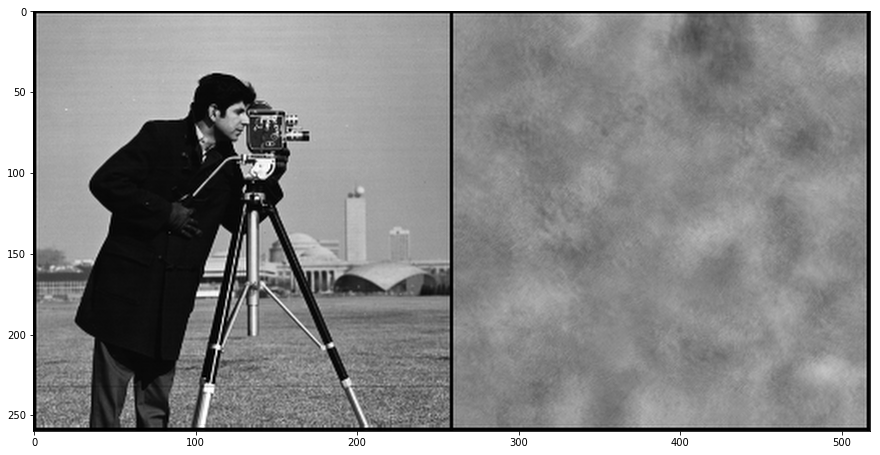

out_HR (1, 256, 256)
out_HRion 00001    PSNR_LR -31.486   PSNR_HR 12.245  (1, 256, 256)
out_HRion 00002    PSNR_LR -30.306   PSNR_HR 11.104  (1, 256, 256)
out_HRion 00003    PSNR_LR -29.233   PSNR_HR 10.266  (1, 256, 256)
out_HRion 00004    PSNR_LR -27.180   PSNR_HR 10.203  (1, 256, 256)
out_HRion 00005    PSNR_LR -25.553   PSNR_HR 9.216  (1, 256, 256)
out_HRion 00006    PSNR_LR -23.452   PSNR_HR 8.577  (1, 256, 256)
out_HRion 00007    PSNR_LR -21.121   PSNR_HR 7.851  (1, 256, 256)
out_HRion 00008    PSNR_LR -18.924   PSNR_HR 7.325  (1, 256, 256)
out_HRion 00009    PSNR_LR -16.628   PSNR_HR 6.926  (1, 256, 256)
out_HRion 00010    PSNR_LR -14.385   PSNR_HR 6.635  (1, 256, 256)
out_HRion 00011    PSNR_LR -12.261   PSNR_HR 6.421  (1, 256, 256)
out_HRion 00012    PSNR_LR -10.220   PSNR_HR 6.259  (1, 256, 256)
out_HRion 00013    PSNR_LR -8.200   PSNR_HR 6.134  (1, 256, 256)
out_HRion 00014    PSNR_LR -6.189   PSNR_HR 6.035  (1, 256, 256)
out_HRion 00015    PSNR_LR -4.253   PSNR_HR 5.961  (1

KeyboardInterrupt: 

In [6]:
psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
num_iter=5000
reg_noise_std = 0.03
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)